In [2]:
# train_4ch_fasterrcnn_with_accuracy.py

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from tqdm import tqdm  # pip install tqdm

# ─── Data loading utilities ────────────────────────────────────────────────────

def load_rgb(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def load_depth(path: Path) -> np.ndarray:
    d = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    d = d.astype(np.float32)
    return d / (d.max() + 1e-6)

def parse_yolo_labels(path: Path, img_shape: tuple) -> torch.Tensor:
    H, W = img_shape
    boxes = []
    if path.exists():
        with open(path, 'r') as f:
            for line in f:
                cls, xc, yc, w, h = map(float, line.split())
                x0 = (xc - w/2) * W;  y0 = (yc - h/2) * H
                x1 = (xc + w/2) * W;  y1 = (yc + h/2) * H
                boxes.append([x0, y0, x1, y1, int(cls)])
    if boxes:
        return torch.tensor(boxes, dtype=torch.float32)
    return torch.zeros((0,5), dtype=torch.float32)

def collate_fn(batch):
    return tuple(zip(*batch))


# ─── Dataset ───────────────────────────────────────────────────────────────────

class EarlyFusionDataset(Dataset):
    def __init__(self, root: str):
        root = Path(root)
        self.rgb_files = sorted((root/"rgb").glob("*.jpg"))

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path   = self.rgb_files[idx]
        base       = rgb_path.stem
        depth_path = rgb_path.parent.parent/"depth"/f"{base}.png"
        label_path = rgb_path.parent.parent/"labels"/f"{base}.txt"

        rgb   = load_rgb(rgb_path)                   # H×W×3
        depth = load_depth(depth_path)[..., None]    # H×W×1

        fused = np.concatenate([rgb, depth], axis=2) 
        fused = np.array(fused, dtype=np.float32)    # ensure float32

        boxes   = parse_yolo_labels(label_path, rgb.shape[:2])  # N×5
        fused_t = torch.from_numpy(fused.transpose(2,0,1))      # 4×H×W

        return fused_t, {
            "boxes":  boxes[:, :4],        # N×4
            "labels": boxes[:, 4].long() + 1 # N
        }


# ─── Model factory ────────────────────────────────────────────────────────────

def get_fasterrcnn_4ch(num_classes: int):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Patch conv1 → accept 4 channels
    conv1 = model.backbone.body.conv1
    old_w = conv1.weight.clone()  # [64,3,7,7]
    new_conv1 = torch.nn.Conv2d(
        in_channels=4,
        out_channels=conv1.out_channels,
        kernel_size=conv1.kernel_size,
        stride=conv1.stride,
        padding=conv1.padding,
        bias=False
    )
    with torch.no_grad():
        new_conv1.weight[:, :3] = old_w
        new_conv1.weight[:, 3:].zero_()
    model.backbone.body.conv1 = new_conv1

    # Swap predictor head
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

    # Patch normalization for depth channel
    model.transform.image_mean = [0.485, 0.456, 0.406, 0.0]
    model.transform.image_std  = [0.229, 0.224, 0.225, 1.0]
    return model


# ─── Training & evaluation loops ──────────────────────────────────────────────

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch} [train]", unit="batch")
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(train_loss=f"{loss.item():.4f}")
    pbar.close()
    return total_loss / len(loader)

def evaluate_loss(model, loader, device, epoch):
    model.train()  # keep in train mode so model returns loss dict
    total_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch} [eval] ", unit="batch")
    with torch.no_grad():
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()
            pbar.set_postfix(val_loss=f"{loss.item():.4f}")
    pbar.close()
    return total_loss / len(loader)

@torch.no_grad()
def compute_single_obj_acc(model, loader, device, iou_thresh=0.5):
    model.eval()
    correct = 0
    total   = 0

    for images, targets in loader:
        images = [img.to(device) for img in images]
        outputs = model(images)  # list of dicts

        for out, tgt in zip(outputs, targets):
            gt_boxes = tgt["boxes"]
            # skip if no ground-truth
            if gt_boxes.numel() == 0:
                continue

            gt_box = gt_boxes[0].to(device)
            total += 1

            # skip if no predictions
            if out["boxes"].numel() == 0:
                continue

            # pick highest-score pred
            idx = out["scores"].argmax()
            pred_box = out["boxes"][idx]

            # compute IoU
            xA = torch.max(gt_box[0], pred_box[0])
            yA = torch.max(gt_box[1], pred_box[1])
            xB = torch.min(gt_box[2], pred_box[2])
            yB = torch.min(gt_box[3], pred_box[3])
            inter = (xB - xA).clamp(min=0) * (yB - yA).clamp(min=0)
            area_gt = (gt_box[2]-gt_box[0]) * (gt_box[3]-gt_box[1])
            area_pr = (pred_box[2]-pred_box[0]) * (pred_box[3]-pred_box[1])
            union = area_gt + area_pr - inter
            iou = inter / union

            if iou >= iou_thresh:
                correct += 1

    return correct / total if total > 0 else 0.0


# ─── Main script ──────────────────────────────────────────────────────────────

if __name__ == "__main__":
    ROOT_DIR     = "Processed_data"
    NUM_CLASSES  = 6 + 1
    BATCH_SIZE   = 8
    LR           = 1e-4
    WEIGHT_DECAY = 1e-4
    NUM_EPOCHS   = 50
    PATIENCE     = 5
    VAL_SPLIT    = 0.2
    SEED         = 42

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # prepare dataset & loaders
    ds = EarlyFusionDataset(ROOT_DIR)
    total = len(ds)
    val_n = int(total * VAL_SPLIT)
    train_n = total - val_n
    train_ds, val_ds = random_split(
        ds, [train_n, val_n],
        generator=torch.Generator().manual_seed(SEED)
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, collate_fn=collate_fn)

    model     = get_fasterrcnn_4ch(NUM_CLASSES).to(device)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    best_val = float("inf")
    no_improve = 0

    for epoch in range(1, NUM_EPOCHS+1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
        vl_loss = evaluate_loss(model, val_loader, device, epoch)
        acc     = compute_single_obj_acc(model, val_loader, device)

        print(f"Epoch {epoch:02d} — train_loss: {tr_loss:.4f}, "
              f"val_loss: {vl_loss:.4f}, accuracy: {acc*100:.1f}%")

        if vl_loss < best_val:
            best_val = vl_loss
            no_improve = 0
            torch.save(model.state_dict(), "best_fasterrcnn_4ch1.pth")
            print("  ↳ Validation loss improved; model saved.")
        else:
            no_improve += 1
            print(f"  ↳ No improvement for {no_improve}/{PATIENCE} epochs.")
            if no_improve >= PATIENCE:
                print("Early stopping triggered.")
                break

    print("Training complete.")


Epoch 1 [eval] : 100%|██████████| 33/33 [00:06<00:00,  5.24batch/s, val_loss=0.0817]


Epoch 01 — train_loss: 0.1931, val_loss: 0.0865, accuracy: 90.1%
  ↳ Validation loss improved; model saved.


Epoch 2 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.14batch/s, val_loss=0.0583]


Epoch 02 — train_loss: 0.0699, val_loss: 0.0672, accuracy: 92.7%
  ↳ Validation loss improved; model saved.


Epoch 3 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.06batch/s, val_loss=0.0514]


Epoch 03 — train_loss: 0.0541, val_loss: 0.0551, accuracy: 92.4%
  ↳ Validation loss improved; model saved.


Epoch 4 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.11batch/s, val_loss=0.0394]


Epoch 04 — train_loss: 0.0428, val_loss: 0.0511, accuracy: 92.0%
  ↳ Validation loss improved; model saved.


Epoch 5 [eval] : 100%|██████████| 33/33 [00:05<00:00,  5.96batch/s, val_loss=0.0389]


Epoch 05 — train_loss: 0.0398, val_loss: 0.0453, accuracy: 91.6%
  ↳ Validation loss improved; model saved.


Epoch 6 [eval] : 100%|██████████| 33/33 [00:07<00:00,  4.59batch/s, val_loss=0.0376]


Epoch 06 — train_loss: 0.0353, val_loss: 0.0436, accuracy: 91.2%
  ↳ Validation loss improved; model saved.


Epoch 7 [eval] : 100%|██████████| 33/33 [00:07<00:00,  4.61batch/s, val_loss=0.0384]


Epoch 07 — train_loss: 0.0325, val_loss: 0.0468, accuracy: 91.2%
  ↳ No improvement for 1/5 epochs.


Epoch 8 [eval] : 100%|██████████| 33/33 [00:07<00:00,  4.55batch/s, val_loss=0.0367]


Epoch 08 — train_loss: 0.0295, val_loss: 0.0412, accuracy: 91.2%
  ↳ Validation loss improved; model saved.


Epoch 9 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.00batch/s, val_loss=0.0389]


Epoch 09 — train_loss: 0.0283, val_loss: 0.0412, accuracy: 91.2%
  ↳ Validation loss improved; model saved.


Epoch 10 [eval] : 100%|██████████| 33/33 [00:07<00:00,  4.56batch/s, val_loss=0.0597]


Epoch 10 — train_loss: 0.0257, val_loss: 0.0418, accuracy: 91.6%
  ↳ No improvement for 1/5 epochs.


Epoch 11 [eval] : 100%|██████████| 33/33 [00:05<00:00,  5.77batch/s, val_loss=0.0299]


Epoch 11 — train_loss: 0.0321, val_loss: 0.0434, accuracy: 90.8%
  ↳ No improvement for 2/5 epochs.


Epoch 12 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.05batch/s, val_loss=0.0340]


Epoch 12 — train_loss: 0.0231, val_loss: 0.0363, accuracy: 90.5%
  ↳ Validation loss improved; model saved.


Epoch 13 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.02batch/s, val_loss=0.0250]


Epoch 13 — train_loss: 0.0220, val_loss: 0.0365, accuracy: 92.7%
  ↳ No improvement for 1/5 epochs.


Epoch 14 [eval] : 100%|██████████| 33/33 [00:07<00:00,  4.63batch/s, val_loss=0.0240]


Epoch 14 — train_loss: 0.0214, val_loss: 0.0320, accuracy: 90.8%
  ↳ Validation loss improved; model saved.


Epoch 15 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.02batch/s, val_loss=0.0272]


Epoch 15 — train_loss: 0.0200, val_loss: 0.0380, accuracy: 91.6%
  ↳ No improvement for 1/5 epochs.


Epoch 16 [eval] : 100%|██████████| 33/33 [00:05<00:00,  5.56batch/s, val_loss=0.0248]


Epoch 16 — train_loss: 0.0192, val_loss: 0.0357, accuracy: 92.0%
  ↳ No improvement for 2/5 epochs.


Epoch 17 [eval] : 100%|██████████| 33/33 [00:05<00:00,  5.98batch/s, val_loss=0.0249]


Epoch 17 — train_loss: 0.0185, val_loss: 0.0359, accuracy: 91.6%
  ↳ No improvement for 3/5 epochs.


Epoch 18 [eval] : 100%|██████████| 33/33 [00:05<00:00,  6.06batch/s, val_loss=0.0375]


Epoch 18 — train_loss: 0.0195, val_loss: 0.0391, accuracy: 92.4%
  ↳ No improvement for 4/5 epochs.


Epoch 19 [eval] : 100%|██████████| 33/33 [00:05<00:00,  5.98batch/s, val_loss=0.0220]


Epoch 19 — train_loss: 0.0186, val_loss: 0.0353, accuracy: 92.4%
  ↳ No improvement for 5/5 epochs.
Early stopping triggered.
Training complete.


Eval: 100%|██████████| 66/66 [00:04<00:00, 13.43it/s]



Overall accuracy (IoU≥0.5): 97.88%



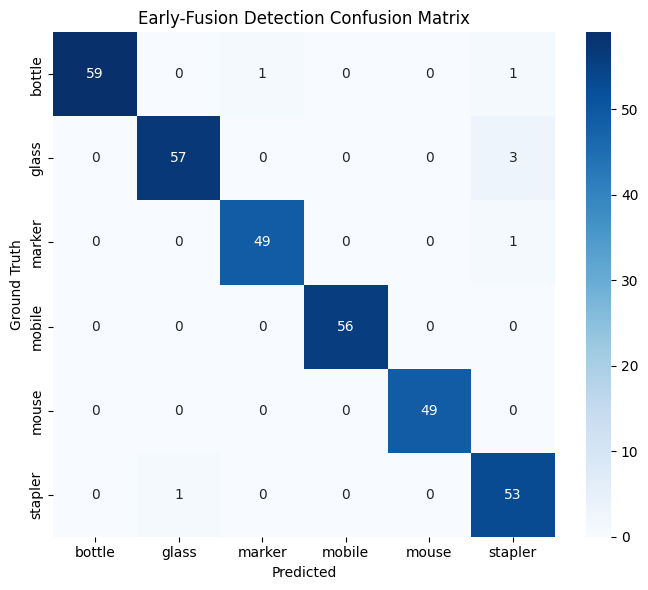

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

# import your training definitions
# from train_4ch_fasterrcnn_with_accuracy import (
#     get_fasterrcnn_4ch,
#     EarlyFusionDataset,
#     collate_fn
# )

def compute_iou(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    uni  = areaA + areaB - inter
    return inter/uni if uni>0 else 0.0

def evaluate(model, loader, device,
             iou_thresh=0.5, score_thresh=0.5, label_map=None):
    gt_list, pred_list = [], []
    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Eval"):
            images = [img.to(device) for img in images]
            outs   = model(images)
            for out, tgt in zip(outs, targets):
                gt_boxes  = tgt["boxes"].cpu().numpy()
                gt_labels = tgt["labels"].cpu().numpy()
                pb, pl, ps = (
                    out["boxes"].cpu().numpy(),
                    out["labels"].cpu().numpy(),
                    out["scores"].cpu().numpy()
                )
                keep = ps >= score_thresh
                pb, pl = pb[keep], pl[keep]
                if len(gt_boxes)==0 or len(pb)==0:
                    continue
                for gbox, glab in zip(gt_boxes, gt_labels):
                    ious = np.array([compute_iou(gbox, xxx) for xxx in pb])
                    j    = ious.argmax()
                    if ious[j] >= iou_thresh:
                        gt_list.append(int(glab))
                        pred_list.append(int(pl[j]))

    # accuracy
    acc = accuracy_score(gt_list, pred_list)
    print(f"\nOverall accuracy (IoU≥{iou_thresh}): {acc*100:.2f}%\n")

    # confusion matrix
    classes = sorted(label_map.keys())
    names   = [label_map[c] for c in classes]
    cm = confusion_matrix(gt_list, pred_list, labels=classes)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=names, yticklabels=names)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("Early-Fusion Detection Confusion Matrix")
    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ROOT_DIR  = "Processed_data"
    WEIGHTS   = "best_fasterrcnn_4ch1.pth"
    # 1→bottle, 2→glass, …, 6→stapler
    LABEL_MAP = {
        1: "bottle",
        2: "glass",
        3: "marker",
        4: "mobile",
        5: "mouse",
        6: "stapler"
    }

    # build & load
    model = get_fasterrcnn_4ch(
    num_classes=len(LABEL_MAP)+1,
    weights_path=WEIGHTS,
    device=DEVICE
)

    # val split
    ds = EarlyFusionDataset(ROOT_DIR)
    n_val = int(len(ds) * 0.2)
    _, val_ds = random_split(
        ds, [len(ds)-n_val, n_val],
        generator=torch.Generator().manual_seed(42)
    )
    val_loader = DataLoader(
        val_ds, batch_size=4, shuffle=False,
        num_workers=0, collate_fn=collate_fn
    )

    evaluate(
        model, val_loader, DEVICE,
        iou_thresh=0.5, score_thresh=0.5,
        label_map=LABEL_MAP
    )


In [9]:
import cv2
import torch
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ─── EDIT THESE ────────────────────────────────────────────────────
RGB_PATH   = "Processed_data/rgb/20250718_122756_444339.jpg"
DEPTH_PATH = "Processed_data/depth/20250718_122756_444339.png"   # 16-bit depth map
WEIGHTS    = "best_fasterrcnn_4ch1.pth"        # your trained weights
SCORE_THR  = 0.5
# map class IDs 0–5 to names:
LABEL_MAP = {
    1: "bottle",
    2: "glass",
    3: "marker",
    4: "mobile",
    5: "mouse",
    6: "stapler"
}

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ─────────────────────────────────────────────────────────────────

# ─── Build & load the 4-channel model ─────────────────────────────
def get_model(num_classes, weights_path):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # patch conv1 → 4 channels
    conv1 = model.backbone.body.conv1
    w_old = conv1.weight.clone()
    conv1_new = torch.nn.Conv2d(
        4, conv1.out_channels,
        kernel_size=conv1.kernel_size,
        stride=conv1.stride,
        padding=conv1.padding,
        bias=False
    )
    with torch.no_grad():
        conv1_new.weight[:, :3] = w_old
        conv1_new.weight[:, 3:].zero_()
    model.backbone.body.conv1 = conv1_new

    # swap out the predictor for your #classes
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

    # fix normalization (depth channel un-normalized)
    model.transform.image_mean = [0.485,0.456,0.406,0.0]
    model.transform.image_std  = [0.229,0.224,0.225,1.0]

    ckpt = torch.load(weights_path, map_location=DEVICE)
    model.load_state_dict(ckpt)
    return model.to(DEVICE).eval()

# ─── Inference helper ───────────────────────────────────────────────
def draw_boxes(img, preds, label_map, thr):
    out = img.copy()
    for box, score, cid in zip(preds["boxes"], preds["scores"], preds["labels"]):
        if score < thr: continue
        x0,y0,x1,y1 = map(int, box.tolist())
        name = label_map.get(int(cid), str(int(cid)))
        cv2.rectangle(out, (x0,y0), (x1,y1), (0,255,0), 2)
        cv2.putText(out, f"{name}:{score:.2f}", (x0, y0-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return out

# ─── Load, fuse, predict ─────────────────────────────────────────────
model = get_model(len(LABEL_MAP)+1, WEIGHTS)

# load RGB
rgb = cv2.imread(RGB_PATH, cv2.IMREAD_COLOR)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

# load depth and normalize to [0,1]
depth = cv2.imread(str(DEPTH_PATH), cv2.IMREAD_UNCHANGED)
depth = depth.astype(np.float32)
depth = depth / (depth.max() + 1e-6)

# fuse into 4-channel H×W×4 and build batch
fused = np.concatenate([rgb.astype(np.float32)/255.0, depth[...,None]], axis=2)
batch = torch.from_numpy(fused.transpose(2,0,1)).unsqueeze(0).to(DEVICE)

# forward
with torch.no_grad():
    preds = model(batch)[0]

# visualize
vis = draw_boxes(rgb, preds, LABEL_MAP, SCORE_THR)
cv2.imshow("Predictions", cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:
# predict_realsense_cell.py

import cv2
import torch
import numpy as np
import pyrealsense2 as rs
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ─── Edit these ────────────────────────────────────────────────────────────────
WEIGHTS   = "best_fasterrcnn_4ch1.pth"
SCORE_THR = 0.5
LABEL_MAP = {
    1: "bottle",
    2: "glass",
    3: "marker",
    4: "mobile",
    5: "mouse",
    6: "stapler"
}

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WIDTH, HEIGHT, FPS = 640, 480, 30
# ───────────────────────────────────────────────────────────────────────────────

def get_fasterrcnn_4ch(num_classes, weights_path, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    conv1 = model.backbone.body.conv1
    old_w = conv1.weight.clone()
    new_conv = torch.nn.Conv2d(4, conv1.out_channels,
                               kernel_size=conv1.kernel_size,
                               stride=conv1.stride,
                               padding=conv1.padding,
                               bias=False)
    with torch.no_grad():
        new_conv.weight[:, :3] = old_w
        new_conv.weight[:, 3:].zero_()
    model.backbone.body.conv1 = new_conv

    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

    model.transform.image_mean = [0.485,0.456,0.406,0.0]
    model.transform.image_std  = [0.229,0.224,0.225,1.0]

    ckpt = torch.load(weights_path, map_location=device)
    model.load_state_dict(ckpt)
    return model.to(device).eval()

# build model
model = get_fasterrcnn_4ch(len(LABEL_MAP)+1, WEIGHTS, DEVICE)

# configure RealSense
pipe = rs.pipeline()
cfg  = rs.config()
cfg.enable_stream(rs.stream.depth, WIDTH, HEIGHT, rs.format.z16, FPS)
cfg.enable_stream(rs.stream.color, WIDTH, HEIGHT, rs.format.bgr8, FPS)
pipe.start(cfg)

try:
    while True:
        frames = pipe.wait_for_frames()
        depth_f = frames.get_depth_frame()
        color_f = frames.get_color_frame()
        if not depth_f or not color_f:
            continue

        depth = np.asanyarray(depth_f.get_data()).astype(np.float32)
        color = np.asanyarray(color_f.get_data())           # BGR

        # normalize and fuse
        depth_norm = depth / (depth.max()+1e-6)
        rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
        fused = np.concatenate([
            rgb.astype(np.float32)/255.0,
            depth_norm[...,None]
        ], axis=2)
        inp = torch.from_numpy(fused.transpose(2,0,1))\
                   .unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            preds = model(inp)[0]

        # draw on BGR frame
        for box, score, cid in zip(preds["boxes"], preds["scores"], preds["labels"]):
            if score < SCORE_THR:
                continue
            x0,y0,x1,y1 = map(int, box.tolist())
            name = LABEL_MAP.get(int(cid), str(int(cid)))
            cv2.rectangle(color, (x0,y0), (x1,y1), (0,255,0), 2)
            cv2.putText(color, f"{name}:{score:.2f}", (x0,y0-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        cv2.imshow("RealSense Detection", color)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    pipe.stop()
    cv2.destroyAllWindows()
